In [1]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, value_and_grad, jacfwd, jacrev
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Internal modules
import os
import sys
current_file_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_file_dir, ".."))
sys.path.append(module_path)
from diffPLOG2TROE.falloff import compute_falloff
from diffPLOG2TROE.pressure_logarithmic import compute_plog
from diffPLOG2TROE.refitter import rmse_loss_function, ratio_loss_function, compute_pressure_limits

In [2]:
constant_plog = jnp.array([
    [1.00E-01, 7.23E+29, -5.32E+00, 110862.4],
    [1.00E+00, 3.50E+30, -5.22E+00, 111163.3],
    [1.00E+01, 1.98E+31, -5.16E+00, 111887.8],
    [1.00E+02, 2.69E+31, -4.92E+00, 112778.7],
], dtype=jnp.float64)
T_range = jnp.linspace(500, 2500, 100)
P_range = jnp.logspace(1.1, 1.7, 100)

print(f"Temperature range -> {T_range[0]} - {T_range[-1]}")
print(f"Pressure range    -> {P_range[0]} - {P_range[-1]}")

fg = jnp.array([
    1.98E+31, -5.16E+00, 111887.8,
    2.69E+31, -4.92E+00, 112778.7,
    0.1, 1., 1.0e+10, 1.0e+10
], dtype=jnp.float64)
# fg = compute_pressure_limits(constant_plog, fg, T_range, P_range)
k_plog = compute_plog(constant_plog, T_range, P_range)

Temperature range -> 500.0 - 2500.0
Pressure range    -> 12.589254117941675 - 50.11872336272722


In [3]:
%%time
# Global Optimization on all the parameters
# data = (T_range, P_range, k_plog, fg[:6])
data = (T_range, P_range, k_plog)
loss_function = rmse_loss_function
print(f"Initial value for the loss_function: {loss_function(fg, data)}")

# NELDER-MEAD
res = minimize(
    loss_function,
    fg,
    args=(data,),
    method="nelder-mead",
    options={
        "xatol": 1e-10,
        "fatol": 1e-15,
        "maxfev": 100000,
        "disp": True,
    }
)

fg_local = res.x
print(fg_local)

Initial value for the loss_function: 95.14410783455618
Optimization terminated successfully.
         Current function value: 0.003284
         Iterations: 3559
         Function evaluations: 5431
[ 1.03975641e+32 -3.70788072e+00  1.12081598e+05  9.62067016e+31
 -4.74832625e+00  1.10072417e+05  5.75022159e-02  4.20243116e+00
 -4.99230391e+08  5.08319131e+04]
CPU times: user 2.22 s, sys: 241 ms, total: 2.46 s
Wall time: 1.03 s


In [4]:
# data = (T_range, P_range, k_plog, fg[:6])
f = lambda p, data: loss_function(p, data)
def hessian(f):
    return jacfwd(jacrev(f))
jacobian = grad(loss_function)
hesso = hessian(f)(fg, data)

res = minimize(
     loss_function,
     fg_local,
     args=(data,),
     jac=jacobian,
     hess=hessian(f),
     method="trust-ncg",
     options={"gtol": 1e-12, "disp": True}
)

Optimization terminated successfully.
         Current function value: 0.003284
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
         Hessian evaluations: 23


In [5]:
print(res)
print(fg_local)
print(res.x)
print(fg_local - res.x)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.0032837858671623003
       x: [ 1.040e+32 -3.707e+00  1.121e+05  9.621e+31 -4.747e+00
            1.101e+05  5.709e-02  4.202e+00 -4.992e+08  5.107e+04]
     nit: 23
     jac: [-5.516e-36 -7.628e-14 -9.315e-15 -2.434e-36 -3.045e-14
            4.449e-14 -2.834e-13  2.550e-52  6.843e-17 -6.159e-14]
    nfev: 24
    njev: 24
    nhev: 23
    hess: [[ 9.499e-65  7.143e-32 ...  8.826e-47 -8.435e-45]
           [ 7.143e-32  5.394e+01 ...  6.776e-14 -6.826e-12]
           ...
           [ 8.826e-47  6.776e-14 ...  2.742e-25 -1.158e-26]
           [-8.435e-45 -6.826e-12 ... -1.158e-26  2.551e-17]]
[ 1.03975641e+32 -3.70788072e+00  1.12081598e+05  9.62067016e+31
 -4.74832625e+00  1.10072417e+05  5.75022159e-02  4.20243116e+00
 -4.99230391e+08  5.08319131e+04]
[ 1.03975641e+32 -3.70727390e+00  1.12083649e+05  9.62067016e+31
 -4.74660622e+00  1.10057827e+05  5.70878248e-02  4.20243116e+00
 -4.99230391e+08  5.1

In [6]:
refitted_troe = (
    jnp.array([
        [res.x[0], res.x[1], res.x[2], 0.000],  # HPL, the fourth term is dummy
        [res.x[3], res.x[4], res.x[5], 0.000],  # LPL, the fourth term is dummy
        [res.x[6], res.x[7], res.x[8], res.x[9]],  # TROE parameters
    ], dtype=jnp.float64),
    1, # Lindemann -> 0, TROE -> 1, SRI -> 2
)
k_refitted = compute_falloff(refitted_troe, T_range, P_range)

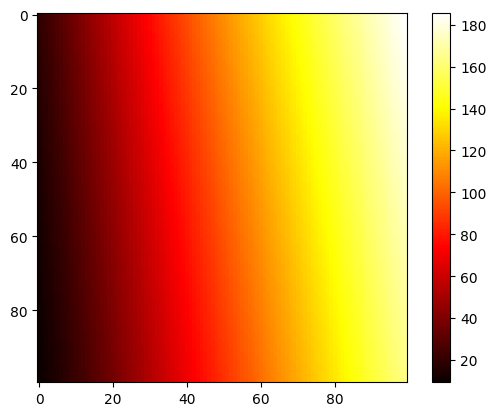

In [7]:
ratio = k_plog / k_refitted
fig, ax = plt.subplots()

c = ax.imshow(ratio, cmap='hot', interpolation='nearest')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()